# Pruebas con Albumentations

In [106]:
%load_ext autoreload
%autoreload 2
import pandas as pd
from pathlib import Path
from detection_helper import create_DF
from matplotlib import pyplot as plt
import numpy as np

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [107]:
import albumentations as A
from PIL import Image
import matplotlib.patches as patches


In [108]:
import pickle
with open("data.pkl","rb") as f:
    (df_train, df_val, train_files, val_files, classes_idx, cant_classes, classes) = pickle.load(f)

In [109]:
with open("anchor_boxes.pkl", "rb") as f:
    anchor_boxes = pickle.load(f)
cant_anchor_boxes = len(anchor_boxes)

In [110]:
transform = A.Compose([
    A.RandomCrop(width=512, height=512),
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
], bbox_params=A.BboxParams(format='coco', min_area=1024, min_visibility=0.1))

In [111]:
df_train.loc[0]

label                                                     Apple
left                                                     236.16
top                                                           0
right                                                    625.92
bottom                                                  342.141
height                                                     1024
width                                                       683
image         Dataset/train/Apple_Grape_Cantaloupe_Watermelo...
image_name                                     837bf3be7055dc46
center_x                                                 431.04
center_y                                                 171.07
delta_x                                                  389.76
delta_y                                                 342.141
Name: 0, dtype: object

In [139]:
img_nbr=100
image_name = train_files[img_nbr].stem
image_file = df_train[df_train["image_name"] == image_name]["image"]

In [140]:
image_name

'052beb2e5402ccd4'

In [141]:
image_file.values[0]

PosixPath('Dataset/train/Apple_Grape_Cantaloupe_Watermelon_Pomegranate_Pineapple_Peach_Mango_Banana_Lemon_Tomato_Strawberry_Pear/052beb2e5402ccd4.jpg')

In [142]:
image = np.array(Image.open(image_file.values[0]))
bboxes = df_train[df_train["image"]==image_file.values[0]][["left","top","delta_x","delta_y","label"]]

In [143]:
bboxes.values

array([[247.68, 124.094871, 67.19999999999999, 104.90490000000001,
        'Tomato'],
       [268.8, 280.173027, 151.03999999999996, 108.74316900000002,
        'Tomato'],
       [272.64, 371.645016, 183.68, 159.91642500000017, 'Tomato'],
       [361.6, 23.02824, 131.2, 108.74248200000001, 'Tomato'],
       [451.2, 319.192566, 110.07999999999998, 128.57273700000002,
        'Tomato'],
       [500.48, 432.413601, 182.39999999999998, 177.82651500000014,
        'Tomato'],
       [565.12, 152.880171, 211.20000000000005, 131.13112500000003,
        'Tomato'],
       [621.44, 314.075103, 168.31999999999994, 174.62853, 'Tomato'],
       [661.12, 30.704091, 76.15999999999997, 73.56121200000001,
        'Tomato'],
       [727.68, 287.848878, 143.36, 167.59227599999997, 'Tomato'],
       [769.92, 154.15936499999995, 103.68000000000006,
        138.80697600000005, 'Tomato']], dtype=object)

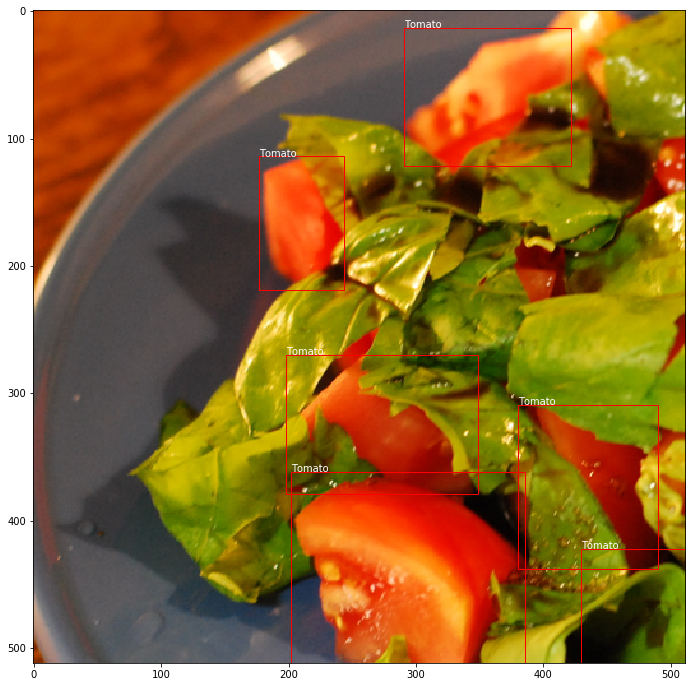

In [144]:
transformed = transform(image=image, bboxes=bboxes.values)
# Create figure and axes
fig,ax = plt.subplots(1, figsize=[12,12])
plt.imshow(transformed["image"])
for bbox in transformed["bboxes"]:
    rect = patches.Rectangle((bbox[0],bbox[1]),bbox[2],bbox[3],linewidth=1,edgecolor='r',facecolor='none')
    # Add the patch to the Axes
    ax.add_patch(rect)
    plt.text(bbox[0],bbox[1],bbox[4], c="w")
plt.show()

In [145]:
bboxes_aug = transformed["bboxes"]
image_aug = transformed["image"]

# En qué gridcell anoto cada bbox?

supongamos gridcells de 32x32

In [146]:
# Es útil tener una función que reciba los bounding boxes y me devuelva en qué gridcell debo anotar cada uno
def get_gridcell(bboxes,grid_size):
    print( [((bbox[0] + bbox[2]/2), 
             (bbox[1] + bbox[3]/2)) for bbox in bboxes_aug])
    grid_cells = [((bbox[0] + bbox[2]/2)//grid_size[0], 
                   (bbox[1] + bbox[3]/2)//grid_size[1]) for bbox in bboxes_aug]
    return grid_cells

In [147]:
bboxes_aug

[(176.68, 114.094871, 67.19999999999999, 104.90489999999998, 'Tomato'),
 (197.8, 270.173027, 151.03999999999996, 108.74316900000002, 'Tomato'),
 (201.64, 361.645016, 183.68, 150.354984, 'Tomato'),
 (290.6, 13.02824, 131.2, 108.74248200000001, 'Tomato'),
 (380.2, 309.192566, 110.07999999999998, 128.57273700000002, 'Tomato'),
 (429.48, 422.413601, 82.51999999999998, 89.58639899999997, 'Tomato')]

In [148]:
get_gridcell(bboxes_aug,[32,32])

[(210.28, 166.54732099999998), (273.32, 324.5446115), (293.48, 436.82250799999997), (356.20000000000005, 67.39948100000001), (435.24, 373.47893450000004), (470.74, 467.2068005)]


[(6.0, 5.0), (8.0, 10.0), (9.0, 13.0), (11.0, 2.0), (13.0, 11.0), (14.0, 14.0)]

In [172]:
# Es exactamente la misma función que antes, pero sin los prints
def get_gridcell(bboxes,grid_size):
    grid_cells = [(int((bbox[0] + bbox[2]/2)//grid_size[0]), 
                   int((bbox[1] + bbox[3]/2)//grid_size[1])) for bbox in bboxes_aug]
    return grid_cells

In [173]:
grid_cells = get_gridcell(bboxes_aug,[32,32]) # grid_cells a los que pertenecen los bounding boxes
grid_cells_u = np.unique(get_gridcell(bboxes_aug,[32,32]),axis=1) #uniques de los grid_cells, esto es por si varios van al mismo gridcell

In [174]:
grid_cells

[(6, 5), (8, 10), (9, 13), (11, 2), (13, 11), (14, 14)]

# Chequeo de IoU con anchor boxes

In [179]:
# Esta función me devuelve el IoU entre un bounding box y cada uno de los anchor boxes para luego decidir en cuáles lo anoto
def anchor_check(anchor_boxes, bbox):
    aux_bbox = np.array(bbox[:-1]).reshape(-1,4).repeat(len(anchor_boxes),axis=0)
    intersects = np.min([anchor_boxes[:,0],aux_bbox[:,2]],axis=0)*np.min([anchor_boxes[:,1],aux_bbox[:,3]],axis=0)
    union = aux_bbox[:,2]*aux_bbox[:,3]+anchor_boxes[:,0]*anchor_boxes[:,1]-intersects
    return intersects/union

In [180]:
# Defino el umbral a partir del cual anoto un bounding box en un anchor box
IoU_alpha = 0.5

In [178]:
annotations = list()
for cell_u in grid_cells_u:
    indexes = [cell_u.tolist() == list(grid_cell) for grid_cell in grid_cells]
    bboxes_cell = [bboxes_aug[idx] for idx,index in enumerate(indexes) if index]
    winners = np.zeros([len(bboxes_cell),len(anchor_boxes)])
    for idx,bbox in enumerate(bboxes_cell):
        winners[idx,:] = anchor_check(anchor_boxes,bbox)
    mask = winners.max(axis=0) > IoU_alpha
    bbox_nbr = winners.argmax(axis=0)
    for ab,(m,b) in enumerate(zip(mask,bbox_nbr)):
        if m:
            annotations.append((*cell_u, ab, *bboxes_cell[b]))

ValueError: zero-size array to reduction operation maximum which has no identity

In [158]:
# grid_cell_x, grid_cell_y, anchor_box, min_x, min_y, delta_x, delta_y, clase
annotations[0]

IndexError: list index out of range

# Conversión del formato de la anotación a YOLO

In [36]:
ann_size = 1 + cant_classes + 4 # confidencia + clase + bbox
y = np.zeros([1,int(512/32),int(512/32),len(anchor_boxes)*ann_size]) #reservo espacio para las anotaciones de 1 imagen

In [37]:
y.shape

(1, 16, 16, 288)

In [41]:
# grid_cell, anchor_box, bbox
for ann in annotations:
    y[0,ann[1],ann[0], ann[2]*ann_size] = 1 # Anoto que hay objeto en este AB
    y[0,ann[1],ann[0], ann[2]*ann_size+1+classes_idx[ann[7]]] = 1 # Anoto la clase del objeto
    y[0,ann[1],ann[0], ann[2]*ann_size+1+cant_classes:ann[2]*ann_size+1+cant_classes+4] = ann[3:7]

In [44]:
annotations[1]

(3,
 11,
 2,
 0.0,
 213.90722300000016,
 229.08000000000004,
 278.06910700000003,
 'Tomato')

In [46]:
y[0,11,3].reshape(-1,ann_size)

array([[  1.      ,   0.      ,   0.      ,   0.      ,   0.      ,
          0.      ,   0.      ,   0.      ,   0.      ,   1.      ,
          0.      ,   0.      ,   0.      ,   0.      ,   0.      ,
        213.907223, 229.08    , 278.069107],
       [  0.      ,   0.      ,   0.      ,   0.      ,   0.      ,
          0.      ,   0.      ,   0.      ,   0.      ,   0.      ,
          0.      ,   0.      ,   0.      ,   0.      ,   0.      ,
          0.      ,   0.      ,   0.      ],
       [  1.      ,   0.      ,   0.      ,   0.      ,   0.      ,
          0.      ,   0.      ,   0.      ,   0.      ,   1.      ,
          0.      ,   0.      ,   0.      ,   0.      ,   0.      ,
        213.907223, 229.08    , 278.069107],
       [  0.      ,   0.      ,   0.      ,   0.      ,   0.      ,
          0.      ,   0.      ,   0.      ,   0.      ,   0.      ,
          0.      ,   0.      ,   0.      ,   0.      ,   0.      ,
          0.      ,   0.      ,   0.      ],
    

# No nos sirve el formato del bbox para YOLO, tenemos que referirlo a la celda


center_x,center_y: 0,0 -> borde superior izquierdo de la celda  
x,y: 1,1 -> borde inferior derecho de la celda  
delta_x y delta_y: 1 para indicar un gridcell de ancho, puede ser mayor a 1  

In [100]:
anns = np.array(annotations)
anns = anns[:,:-1].astype(float)

In [101]:
anns[0]

array([  3.      ,  11.      ,   0.      ,   0.      , 213.907223,
       229.08    , 278.069107])

In [102]:
anns[:,3] = ((anns[:,3]+anns[:,5]/2)-anns[:,0]*32)/32
anns[:,4] = ((anns[:,4]+anns[:,6]/2)-anns[:,1]*32)/32

In [103]:
anns[0]

array([3.00000000e+00, 1.10000000e+01, 0.00000000e+00, 5.79375000e-01,
       2.94305156e-02, 2.29080000e+02, 2.78069107e+02])

In [104]:
213.9+278.07/2

352.935

In [105]:
anns = np.array(annotations)
anns = anns[:,:-1].astype(float)
anns[:,3:5] = ((anns[:,3:5]+anns[:,5:7]/2)-anns[:,0:2]*32)/32
anns[0]

array([3.00000000e+00, 1.10000000e+01, 0.00000000e+00, 5.79375000e-01,
       2.94305156e-02, 2.29080000e+02, 2.78069107e+02])